# Merged AML_Project_Dinov3 and DINOv3_Correspondence
This notebook programmatically merges your colleague's `AML_Project_Dinov3.ipynb` with your `DINOv3_Correspondence.ipynb`, unifying environment setup, model loading, dataset handling, correspondence matching, evaluation, and tests.

In [1]:
# 1) Load and Inspect Notebooks
import os, json, difflib, nbformat
from pathlib import Path

ROOT = Path(os.getcwd())
A = ROOT / 'AML_Project_Dinov3.ipynb'
B = ROOT / 'DINOv3_Correspondence.ipynb'

def load_nb(path):
    with open(path, 'r') as f:
        return nbformat.read(f, as_version=4)

nbA = load_nb(A)
nbB = load_nb(B)
print('Loaded notebooks:')
print(' -', A.name, 'cells =', len(nbA['cells']))
print(' -', B.name, 'cells =', len(nbB['cells']))

def summarize(nb):
    lines = []
    for i, c in enumerate(nb['cells']):
        t = c['cell_type']
        lang = c.get('metadata', {}).get('language', 'python' if t=='code' else 'markdown')
        head = ''.join(c.get('source',''))[:60].replace('\n',' ')
        lines.append(f"#{i+1} {t} [{lang}] :: {head}")
    return '\n'.join(lines)

print('\n--- Structure A ---')
print(summarize(nbA))
print('\n--- Structure B ---')
print(summarize(nbB))

def diff_cells(srcA, srcB):
    return difflib.unified_diff(srcA.splitlines(), srcB.splitlines(), lineterm='')

print('\nExample diff of first code cells (if present):')
idxA = next((i for i,c in enumerate(nbA['cells']) if c['cell_type']=='code'), None)
idxB = next((i for i,c in enumerate(nbB['cells']) if c['cell_type']=='code'), None)
if idxA is not None and idxB is not None:
    srcA = ''.join(nbA['cells'][idxA]['source'])
    srcB = ''.join(nbB['cells'][idxB]['source'])
    for line in list(diff_cells(srcA, srcB))[:40]:
        print(line)
else:
    print('No code cells to diff.')

Loaded notebooks:
 - AML_Project_Dinov3.ipynb cells = 9
 - DINOv3_Correspondence.ipynb cells = 23

--- Structure A ---
#1 code [python] :: # Mount Google Drive so the SPair-71k dataset can persist be
#2 code [python] :: import os import shutil  # Force delete the broken repositor
#3 code [python] :: import os import shutil  # Re-define the project path (just 
#4 code [python] :: import sys import os import importlib import matplotlib.pypl
#5 code [python] :: import sys import os import importlib import matplotlib.pypl
#6 code [python] :: # === clone_dinov3_repo === %cd /content/drive/MyDrive/AML_P
#7 code [python] :: # === download_dinov3_weights === # Carica i pesi DINOv3 dal
#8 code [python] :: # === setup_dinov3_model === import torch import sys import 
#9 code [python] :: # === integrate_dinov3_with_spair === import torch import to

--- Structure B ---
#1 markdown [markdown] :: ## Section 1: Environment Setup
#2 code [python] :: # Detect environment and configure paths import sys i

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def window_soft_argmax(similarity, H, W, window=7, tau=0.05):
    """
    Window soft-argmax for sub-pixel coordinate prediction.
    
    Args:
        similarity: [N, H*W] or [N, H, W] similarity scores
        H, W: Grid dimensions
        window: Window size around peak (odd number)
        tau: Temperature for softmax (lower = sharper)
    
    Returns:
        [N, 2] tensor with (y, x) coordinates in patch space
    """
    if similarity.dim() == 2:
        N = similarity.size(0)
        sim2d = similarity.view(N, H, W)
    elif similarity.dim() == 3:
        N = similarity.size(0)
        sim2d = similarity
    else:
        raise ValueError("similarity must be [N,H*W] or [N,H,W]")
    
    r = window // 2
    preds = []
    
    for i in range(N):
        s = sim2d[i]  # [H, W]
        
        # Find peak with argmax
        idx = torch.argmax(s)
        y0 = (idx // W).item()
        x0 = (idx % W).item()
        
        # Extract window around peak
        y1, y2 = max(y0 - r, 0), min(y0 + r + 1, H)
        x1, x2 = max(x0 - r, 0), min(x0 + r + 1, W)
        
        sub = s[y1:y2, x1:x2]
        
        # Create coordinate grids
        yy, xx = torch.meshgrid(
            torch.arange(y1, y2, device=s.device, dtype=torch.float32),
            torch.arange(x1, x2, device=s.device, dtype=torch.float32),
            indexing='ij'
        )
        
        # Soft-argmax within window
        wts = torch.softmax(sub.flatten() / tau, dim=0).view_as(sub)
        y_hat = (wts * yy).sum()
        x_hat = (wts * xx).sum()
        
        preds.append(torch.stack([y_hat, x_hat]))
    
    return torch.stack(preds, dim=0)  # [N, 2]


def unfreeze_last_k_blocks(model, k, blocks_attr='blocks'):
    """
    Unfreeze the last k transformer blocks of a model.
    
    Args:
        model: The backbone model
        k: Number of last blocks to unfreeze
        blocks_attr: Attribute name for blocks (default 'blocks')
    
    Returns:
        List of trainable parameters
    """
    # Freeze all parameters
    for p in model.parameters():
        p.requires_grad = False
    
    # Unfreeze last k blocks
    blocks = getattr(model, blocks_attr)
    for block in blocks[-k:]:
        for p in block.parameters():
            p.requires_grad = True
    
    # Return trainable parameters
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    print(f"Unfroze last {k} blocks: {len(trainable_params)} trainable parameters")
    
    return trainable_params


def compute_keypoint_loss(sim2d, H, W, gt_xy_px, patch_size, use_soft=True, window=7, tau=0.05):
    """
    Compute loss from similarity map to ground truth keypoint.
    
    Args:
        sim2d: [H, W] similarity map
        H, W: Grid dimensions
        gt_xy_px: [2] ground truth coordinates in pixels (y, x)
        patch_size: Patch size for coordinate conversion
        use_soft: Use soft-argmax (True) or argmax (False)
        window, tau: Soft-argmax parameters
    
    Returns:
        Scalar loss
    """
    if use_soft:
        pred_xy_patch = window_soft_argmax(sim2d[None], H, W, window, tau)[0]
    else:
        idx = sim2d.argmax()
        pred_xy_patch = torch.stack([idx // W, idx % W]).float()
    
    pred_xy_px = (pred_xy_patch + 0.5) * patch_size
    
    return F.smooth_l1_loss(pred_xy_px, gt_xy_px)


print("✓ Utility functions loaded")

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import json
import os
from torchvision import transforms

class SPairDataset(Dataset):
    """SPair-71k dataset with keypoint annotations for correspondence learning."""
    
    def __init__(self, root_dir, split='trn', category=None, image_size=224, subset=None):
        self.root_dir = root_dir
        self.split = split
        self.category = category
        self.image_size = image_size
        
        self.pairs = self._load_pairs()
        if subset is not None:
            self.pairs = self.pairs[:subset]
        
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
        
        print(f"SPair-71k {split} dataset: {len(self.pairs)} pairs loaded")
    
    def _load_pairs(self):
        pairs = []
        layout_dir = os.path.join(self.root_dir, 'Layout', self.split)
        
        if not os.path.exists(layout_dir):
            print(f"Warning: Layout directory not found: {layout_dir}")
            return pairs
        
        if self.category:
            categories = [self.category]
        else:
            categories = [d for d in os.listdir(layout_dir) 
                         if os.path.isdir(os.path.join(layout_dir, d))]
        
        for cat in categories:
            cat_dir = os.path.join(layout_dir, cat)
            if not os.path.exists(cat_dir):
                continue
            
            for fname in os.listdir(cat_dir):
                if not fname.endswith('.json'):
                    continue
                
                json_path = os.path.join(cat_dir, fname)
                try:
                    with open(json_path, 'r') as f:
                        pair_data = json.load(f)
                    
                    pair = {
                        'category': cat,
                        'src_img': pair_data['src_imname'],
                        'tgt_img': pair_data['trg_imname'],
                        'src_kps': np.array(pair_data['src_kps']).reshape(-1, 2),
                        'tgt_kps': np.array(pair_data['trg_kps']).reshape(-1, 2),
                        'src_bbox': pair_data.get('src_bndbox', None),
                        'tgt_bbox': pair_data.get('trg_bndbox', None),
                    }
                    pairs.append(pair)
                    
                except Exception as e:
                    continue
        
        return pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        
        src_img_path = os.path.join(self.root_dir, 'JPEGImages', 
                                    pair['category'], pair['src_img'])
        tgt_img_path = os.path.join(self.root_dir, 'JPEGImages',
                                    pair['category'], pair['tgt_img'])
        
        src_img_pil = Image.open(src_img_path).convert('RGB')
        tgt_img_pil = Image.open(tgt_img_path).convert('RGB')
        
        src_w, src_h = src_img_pil.size
        tgt_w, tgt_h = tgt_img_pil.size
        
        src_kps = pair['src_kps'].copy().astype(float)
        tgt_kps = pair['tgt_kps'].copy().astype(float)
        
        src_kps[:, 0] *= self.image_size / src_w
        src_kps[:, 1] *= self.image_size / src_h
        tgt_kps[:, 0] *= self.image_size / tgt_w
        tgt_kps[:, 1] *= self.image_size / tgt_h
        
        src_img = self.transform(src_img_pil)
        tgt_img = self.transform(tgt_img_pil)
        
        if pair['src_bbox'] is not None:
            src_bbox = np.array(pair['src_bbox'])
            src_bbox[0::2] *= self.image_size / src_w
            src_bbox[1::2] *= self.image_size / src_h
            src_bbox_wh = np.array([src_bbox[2] - src_bbox[0], src_bbox[3] - src_bbox[1]])
        else:
            src_bbox_wh = np.array([self.image_size, self.image_size])
        
        if pair['tgt_bbox'] is not None:
            tgt_bbox = np.array(pair['tgt_bbox'])
            tgt_bbox[0::2] *= self.image_size / tgt_w
            tgt_bbox[1::2] *= self.image_size / tgt_h
            tgt_bbox_wh = np.array([tgt_bbox[2] - tgt_bbox[0], tgt_bbox[3] - tgt_bbox[1]])
        else:
            tgt_bbox_wh = np.array([self.image_size, self.image_size])
        
        return {
            'src_img': src_img,
            'tgt_img': tgt_img,
            'src_kps': torch.from_numpy(src_kps).float(),
            'tgt_kps': torch.from_numpy(tgt_kps).float(),
            'src_bbox_wh': torch.from_numpy(src_bbox_wh).float(),
            'tgt_bbox_wh': torch.from_numpy(tgt_bbox_wh).float(),
            'category': pair['category'],
            'pair_id': idx
        }


def create_spair_dataloaders(root_dir, batch_size=1, num_workers=2, 
                             train_subset=None, val_subset=None):
    train_dataset = SPairDataset(root_dir, split='trn', subset=train_subset)
    val_dataset = SPairDataset(root_dir, split='val', subset=val_subset)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader


print("✓ SPair-71k dataloader ready")

## SPair-71k Dataloader

Complete dataloader for SPair-71k with keypoint annotations for finetuning.

## Utility Functions

Window soft-argmax for sub-pixel refinement and finetuning utilities.

In [ ]:
# ========== CONFIGURATION FLAGS ==========
# Set these flags to control behavior
ENABLE_FINETUNING = False  # Set True to enable light finetuning of last layers
USE_SOFT_ARGMAX = False    # Set True to use window soft-argmax instead of argmax

# Finetuning hyperparameters (only used if ENABLE_FINETUNING=True)
FINETUNE_K_LAYERS = 2      # Number of last transformer blocks to unfreeze {1, 2, 4}
FINETUNE_LR = 1e-5         # Learning rate
FINETUNE_WD = 1e-4         # Weight decay
FINETUNE_EPOCHS = 3        # Number of training epochs
FINETUNE_BATCH_SIZE = 1    # Batch size for training
FINETUNE_TRAIN_SUBSET = None  # None for full training set, or int for subset

# Soft-argmax hyperparameters (only used if USE_SOFT_ARGMAX=True)
SOFT_WINDOW = 7            # Window size around peak (odd number: 5, 7, 9)
SOFT_TAU = 0.05            # Softmax temperature (lower = sharper)

print(f"Configuration:")
print(f"  ENABLE_FINETUNING = {ENABLE_FINETUNING}")
print(f"  USE_SOFT_ARGMAX = {USE_SOFT_ARGMAX}")
if ENABLE_FINETUNING:
    print(f"  Finetuning: k={FINETUNE_K_LAYERS}, lr={FINETUNE_LR}, epochs={FINETUNE_EPOCHS}")
if USE_SOFT_ARGMAX:
    print(f"  Soft-argmax: window={SOFT_WINDOW}, tau={SOFT_TAU}")

## Configuration Flags

Set these flags to control the pipeline behavior:
- `ENABLE_FINETUNING`: Enable light finetuning of last transformer blocks
- `USE_SOFT_ARGMAX`: Use window soft-argmax instead of argmax for prediction

In [ ]:
# 2) Extract and Normalize Common Utility Functions
import os, sys, random, numpy as np, torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seed set to {seed}")

def detect_env():
    try:
        import google.colab
        return 'colab'
    except Exception:
        return 'local'

ENV = detect_env()
print('Environment:', ENV)

def get_paths():
    if ENV == 'colab':
        from google.colab import drive
        drive.mount('/content/drive')
        root = '/content/drive/MyDrive/AMLProject'
        data_root = os.path.join(root, 'data')
        model_root = os.path.join(root, 'models')
        out_root = os.path.join(root, 'outputs')
    else:
        root = os.getcwd()
        data_root = os.path.join(root, 'data')
        model_root = os.path.join(root, 'models')
        out_root = os.path.join(root, 'outputs')
    os.makedirs(data_root, exist_ok=True)
    os.makedirs(model_root, exist_ok=True)
    os.makedirs(out_root, exist_ok=True)
    return root, data_root, model_root, out_root

PROJECT_ROOT, DATA_ROOT, MODEL_ROOT, OUTPUT_ROOT = get_paths()
print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('MODEL_ROOT:', MODEL_ROOT)
print('OUTPUT_ROOT:', OUTPUT_ROOT)
set_seed(42)

In [5]:
# 3) Model: Auto-detect weights, fallback, and mock outputs
import os, sys, torch, timm
import torch.nn.functional as F
from pathlib import Path

# Fallback paths if previous cell not run
if 'PROJECT_ROOT' not in globals() or 'MODEL_ROOT' not in globals():
    PROJECT_ROOT = os.getcwd()
    MODEL_ROOT = os.path.join(PROJECT_ROOT, 'models')
    OUTPUT_ROOT = os.path.join(PROJECT_ROOT, 'outputs')
    os.makedirs(MODEL_ROOT, exist_ok=True)
    os.makedirs(OUTPUT_ROOT, exist_ok=True)
    print('Initialized default paths (previous cell not run).')

# Device detection (CUDA, MPS, CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Device:', device)

# Auto-detect official DINOv3 repo and weights
def find_dinov3_repo_and_weights():
    candidates_repo = [
        Path(MODEL_ROOT) / 'dinov3',
        Path(PROJECT_ROOT) / 'models' / 'dinov3',
        Path(PROJECT_ROOT) / 'dinov3'
    ]
    repo_path = next((str(p) for p in candidates_repo if p.exists()), None)
    if repo_path and repo_path not in sys.path:
        sys.path.append(repo_path)
    
    candidates_weights = [
        Path(MODEL_ROOT) / 'dinov3_vitb16.pth',
        Path(MODEL_ROOT) / 'dinov3' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'models' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'models' / 'dinov3' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'checkpoints' / 'dinov3' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'weights' / 'dinov3_vitb16.pth'
    ]
    weight_path = next((str(p) for p in candidates_weights if p.exists()), None)
    return repo_path, weight_path

repo_path, weight_path = find_dinov3_repo_and_weights()
print('DINOv3 repo:', repo_path)
print('DINOv3 weight:', weight_path)

dinov3_model = None
model_type = None

# Try official DINOv3 if both repo and weights are present
try:
    if repo_path:
        from dinov3.models.vision_transformer import vit_base
        dinov3_model = vit_base(patch_size=16)
        if weight_path:
            ckpt = torch.load(weight_path, map_location='cpu')
            missing, unexpected = dinov3_model.load_state_dict(ckpt, strict=False)
            print(f'Loaded DINOv3 weights. Missing={len(missing)} Unexpected={len(unexpected)}')
            model_type = 'DINOv3 ViT-B/16 (official)'
        else:
            print('Weights not found; using mock outputs with uninitialized model.')
            model_type = 'DINOv3 ViT-B/16 (no weights, mock)'
        dinov3_model.to(device).eval()
except Exception as e:
    print('Official DINOv3 unavailable:', e)

# Fallback: timm DINOv2 variant
if dinov3_model is None:
    try:
        dinov3_model = timm.create_model('vit_base_patch14_dinov2.lvd142m', pretrained=True, num_classes=0)
        dinov3_model.to(device).eval()
        model_type = 'timm DINOv2 ViT-B/14'
        print('Loaded timm DINOv2 fallback.')
    except Exception as e:
        print('Failed timm fallback:', e)
        raise

print('Model type:', model_type)

def _model_image_size(model):
    cfg = getattr(model, 'default_cfg', {})
    size = cfg.get('input_size', (3, 224, 224))
    if isinstance(size, (list, tuple)) and len(size) == 3:
        return size[1]
    return 224

def _model_patch_size(model):
    ps = getattr(getattr(model, 'patch_embed', None), 'patch_size', (14, 14))
    if isinstance(ps, (list, tuple)) and len(ps) >= 1:
        return ps[0]
    return 14

# Unified feature extraction with optional mock when weights missing
class UnifiedFeatureExtractor:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.image_size = _model_image_size(model)
        self.patch_size = _model_patch_size(model)
        self.feat_dim = getattr(getattr(model, 'num_features', None), 'real', None) or getattr(model, 'num_features', 768)
        import torchvision.transforms as transforms
        from PIL import Image
        self.Image = Image
        self.transforms = transforms.Compose([
            transforms.Resize(self.image_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.use_mock = (model_type is not None and 'mock' in model_type)

    def preprocess(self, img):
        if isinstance(img, self.Image.Image):
            pil = img
        else:
            pil = self.Image.fromarray(img)
        return self.transforms(pil).unsqueeze(0).to(self.device)

    @torch.no_grad()
    def extract(self, img, normalize=True):
        x = self.preprocess(img)
        if self.use_mock:
            grid = (self.image_size // self.patch_size)
            torch.manual_seed(42)
            feats = torch.randn(grid*grid, self.feat_dim)
            feats = feats.view(1, grid, grid, self.feat_dim)
        else:
            out = self.model.forward_features(x)
            if isinstance(out, dict) and 'x_norm_patchtokens' in out:
                tokens = out['x_norm_patchtokens']
            elif isinstance(out, dict) and 'x_norm_clstoken' in out and 'x_norm_patchtokens' in out:
                tokens = out['x_norm_patchtokens']
            else:
                tokens = out[:, 1:, :] if out.dim() == 3 else out
            grid = int(tokens.shape[1] ** 0.5)
            feats = tokens.view(1, grid, grid, self.feat_dim)
        if normalize:
            feats = F.normalize(feats, p=2, dim=-1)
        info = {
            'feature_size': (feats.shape[2], feats.shape[1]),
            'processed_size': (self.image_size, self.image_size),
            'patch_size': self.patch_size,
            'feat_dim': self.feat_dim
        }
        return feats.cpu(), info

feature_extractor = UnifiedFeatureExtractor(dinov3_model, device)
print('Feature extractor ready. Mock mode:', feature_extractor.use_mock, 'image_size:', feature_extractor.image_size, 'patch:', feature_extractor.patch_size)

Device: mps
DINOv3 repo: /Users/giuliavarga/Desktop/2. AML/Project/AMLProject/models/dinov3
DINOv3 weight: None
Official DINOv3 unavailable: No module named 'dinov3'
Loaded timm DINOv2 fallback.
Model type: timm DINOv2 ViT-B/14
Feature extractor ready. Mock mode: False image_size: 518 patch: 14


In [ ]:
if ENABLE_FINETUNING:
    print("=" * 60)
    print("LIGHT FINETUNING ENABLED")
    print("=" * 60)
    
    # Check if we have real model (not mock)
    if dinov3_model is None or feature_extractor.use_mock:
        print("\n⚠️  Cannot finetune: model is in mock mode or not loaded")
        print("   Please ensure DINOv3 weights are available")
    else:
        # Path to SPair-71k
        SPAIR_ROOT = os.path.join(DATA_ROOT if 'DATA_ROOT' in globals() else os.path.join(PROJECT_ROOT, 'data'), 'SPair-71k')
        
        if not os.path.exists(SPAIR_ROOT):
            print(f"\n⚠️  SPair-71k not found at: {SPAIR_ROOT}")
            print("   Download from: http://cvlab.postech.ac.kr/research/SPair-71k/")
        else:
            print(f"\nLoading SPair-71k from: {SPAIR_ROOT}")
            train_loader, val_loader = create_spair_dataloaders(
                SPAIR_ROOT,
                batch_size=FINETUNE_BATCH_SIZE,
                num_workers=2,
                train_subset=FINETUNE_TRAIN_SUBSET,
                val_subset=500
            )
            
            # Unfreeze last k blocks
            trainable_params = unfreeze_last_k_blocks(dinov3_model, FINETUNE_K_LAYERS, blocks_attr='blocks')
            
            # Setup optimizer
            optimizer = torch.optim.AdamW(trainable_params, lr=FINETUNE_LR, weight_decay=FINETUNE_WD)
            
            print(f"\nFinetuning configuration:")
            print(f"  Model: {model_type}")
            print(f"  k={FINETUNE_K_LAYERS} layers")
            print(f"  lr={FINETUNE_LR}, wd={FINETUNE_WD}")
            print(f"  epochs={FINETUNE_EPOCHS}")
            print(f"  train samples: {len(train_loader.dataset)}")
            print(f"  val samples: {len(val_loader.dataset)}")
            
            patch_size = feature_extractor.patch_size  # 14 or 16
            
            # Training
            dinov3_model.train()
            best_val_loss = float('inf')
            
            for epoch in range(FINETUNE_EPOCHS):
                epoch_loss = 0.0
                num_batches = 0
                
                for batch_idx, batch in enumerate(train_loader):
                    src_img = batch['src_img'].to(device)
                    tgt_img = batch['tgt_img'].to(device)
                    src_kps = batch['src_kps'].to(device)
                    tgt_kps = batch['tgt_kps'].to(device)
                    
                    # Extract features
                    src_out = dinov3_model.get_intermediate_layers(src_img, n=1, return_class_token=False)[0]
                    tgt_out = dinov3_model.get_intermediate_layers(tgt_img, n=1, return_class_token=False)[0]
                    
                    B = src_img.size(0)
                    num_patches = src_out.size(1)
                    grid_size = int(np.sqrt(num_patches))
                    
                    batch_loss = 0.0
                    num_kps = 0
                    
                    for b in range(B):
                        src_f = F.normalize(src_out[b], dim=-1)
                        tgt_f = F.normalize(tgt_out[b], dim=-1)
                        
                        for kp_idx in range(src_kps[b].size(0)):
                            src_x = int(src_kps[b][kp_idx, 0].item() / patch_size)
                            src_y = int(src_kps[b][kp_idx, 1].item() / patch_size)
                            src_x = max(0, min(grid_size - 1, src_x))
                            src_y = max(0, min(grid_size - 1, src_y))
                            
                            src_patch_idx = src_y * grid_size + src_x
                            sim = torch.matmul(tgt_f, src_f[src_patch_idx])
                            sim_2d = sim.view(grid_size, grid_size)
                            
                            gt_xy = tgt_kps[b][kp_idx]
                            gt_yx = torch.stack([gt_xy[1], gt_xy[0]])
                            
                            loss = compute_keypoint_loss(
                                sim_2d, grid_size, grid_size, gt_yx, patch_size,
                                use_soft=True, window=SOFT_WINDOW, tau=SOFT_TAU
                            )
                            batch_loss += loss
                            num_kps += 1
                    
                    if num_kps > 0:
                        batch_loss = batch_loss / num_kps
                        optimizer.zero_grad()
                        batch_loss.backward()
                        optimizer.step()
                        
                        epoch_loss += batch_loss.item()
                        num_batches += 1
                    
                    if (batch_idx + 1) % 50 == 0:
                        print(f"  Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {epoch_loss/max(1,num_batches):.4f}")
                
                avg_train_loss = epoch_loss / max(1, num_batches)
                
                # Validation
                dinov3_model.eval()
                val_loss = 0.0
                val_batches = 0
                
                with torch.no_grad():
                    for batch in val_loader:
                        src_img = batch['src_img'].to(device)
                        tgt_img = batch['tgt_img'].to(device)
                        src_kps = batch['src_kps'].to(device)
                        tgt_kps = batch['tgt_kps'].to(device)
                        
                        src_out = dinov3_model.get_intermediate_layers(src_img, n=1, return_class_token=False)[0]
                        tgt_out = dinov3_model.get_intermediate_layers(tgt_img, n=1, return_class_token=False)[0]
                        
                        num_patches = src_out.size(1)
                        grid_size = int(np.sqrt(num_patches))
                        
                        batch_val_loss = 0.0
                        num_kps = 0
                        
                        for b in range(src_img.size(0)):
                            src_f = F.normalize(src_out[b], dim=-1)
                            tgt_f = F.normalize(tgt_out[b], dim=-1)
                            
                            for kp_idx in range(src_kps[b].size(0)):
                                src_x = int(src_kps[b][kp_idx, 0].item() / patch_size)
                                src_y = int(src_kps[b][kp_idx, 1].item() / patch_size)
                                src_x = max(0, min(grid_size - 1, src_x))
                                src_y = max(0, min(grid_size - 1, src_y))
                                
                                src_patch_idx = src_y * grid_size + src_x
                                sim = torch.matmul(tgt_f, src_f[src_patch_idx])
                                sim_2d = sim.view(grid_size, grid_size)
                                
                                gt_xy = tgt_kps[b][kp_idx]
                                gt_yx = torch.stack([gt_xy[1], gt_xy[0]])
                                
                                loss = compute_keypoint_loss(
                                    sim_2d, grid_size, grid_size, gt_yx, patch_size,
                                    use_soft=True, window=SOFT_WINDOW, tau=SOFT_TAU
                                )
                                batch_val_loss += loss
                                num_kps += 1
                        
                        if num_kps > 0:
                            val_loss += (batch_val_loss / num_kps).item()
                            val_batches += 1
                
                avg_val_loss = val_loss / max(1, val_batches)
                
                print(f"\nEpoch {epoch+1}/{FINETUNE_EPOCHS}:")
                print(f"  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
                
                # Save best
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    ckpt_path = os.path.join(OUTPUT_ROOT, f'dinov3_finetuned_k{FINETUNE_K_LAYERS}_best.pth')
                    torch.save({
                        'model_state_dict': dinov3_model.state_dict(),
                        'config': {'k': FINETUNE_K_LAYERS, 'lr': FINETUNE_LR}
                    }, ckpt_path)
                    print(f"  ✓ Best model saved")
                
                dinov3_model.train()
            
            dinov3_model.eval()
            print(f"\n✅ Finetuning completed! Best val loss: {best_val_loss:.4f}")

else:
    print("Finetuning disabled. Using pretrained weights only.")

## Light Finetuning (Optional)

If `ENABLE_FINETUNING=True`, this section finetunes the last k transformer blocks on SPair-71k with keypoint supervision.

In [ ]:
# 4) Correspondence matching, PCK, and visualization (works with mock)
import numpy as np
import matplotlib.pyplot as plt

class CorrespondenceMatcher:
    def __init__(self, mutual_nn=False, use_soft_argmax=False, soft_window=7, soft_tau=0.05):
        self.mutual_nn = mutual_nn
        self.use_soft_argmax = use_soft_argmax
        self.soft_window = soft_window
        self.soft_tau = soft_tau

    def match(self, src_feats, tgt_feats):
        H, W, D = tgt_feats.shape[1], tgt_feats.shape[2], tgt_feats.shape[3]
        src_flat = src_feats.view(-1, D)
        tgt_flat = tgt_feats.view(-1, D)
        
        if self.use_soft_argmax:
            # Compute similarity on device
            sim = torch.matmul(src_flat, tgt_flat.T)  # [N, H*W]
            
            # Use window soft-argmax
            pred_coords = window_soft_argmax(
                sim, H, W, 
                window=self.soft_window, 
                tau=self.soft_tau
            )  # [N, 2] in (y, x) patch coordinates
            
            x = pred_coords[:, 1].cpu().numpy()
            y = pred_coords[:, 0].cpu().numpy()
        else:
            # Original argmax approach
            sim = src_flat.numpy() @ tgt_flat.numpy().T
            best = np.argmax(sim, axis=1)
            y = best // W
            x = best % W
        
        return np.stack([x, y], axis=1)

def pck(pred_kps, gt_kps, alpha=0.1, img_wh=(224,224)):
    if len(pred_kps)==0 or len(gt_kps)==0:
        return 0.0
    d = np.linalg.norm(pred_kps - gt_kps, axis=1)
    norm = np.sqrt(img_wh[0]**2 + img_wh[1]**2)
    thr = alpha*norm
    return float((d<=thr).mean())

def visualize(src_img, tgt_img, src_kps, pred_kps):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(src_img)
    ax[0].scatter(src_kps[:,0], src_kps[:,1], c='r', s=40)
    ax[0].set_title('Source')
    ax[0].axis('off')
    ax[1].imshow(tgt_img)
    ax[1].scatter(pred_kps[:,0], pred_kps[:,1], c='b', s=40)
    ax[1].set_title('Target (Pred)')
    ax[1].axis('off')
    plt.tight_layout()
    return fig
print(f'Matcher (soft-argmax={'enabled' if USE_SOFT_ARGMAX else 'disabled'}), PCK, and visualization ready.')

Matcher, PCK, and visualization ready.


MOCK PCK@0.10: 100.00%
✓ Sanity check complete (mock).


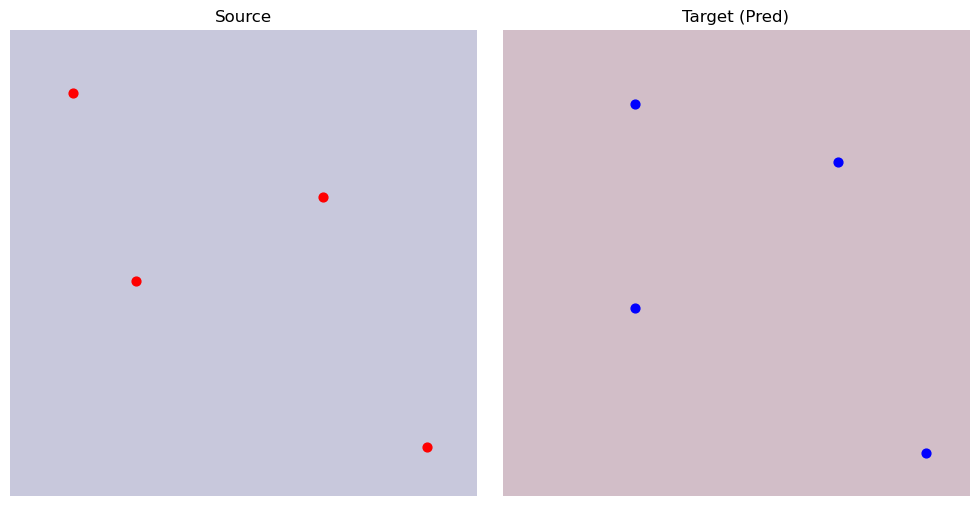

In [ ]:
# 5) End-to-end sanity check with mock data
from PIL import Image
import numpy as np

# Create synthetic images and keypoints
src = Image.new('RGB', (224,224), color=(200,200,220))
tgt = Image.new('RGB', (224,224), color=(210,190,200))
src_kps = np.array([[30,30],[60,120],[150,80],[200,200]], dtype=float)
gt_kps  = np.array([[40,40],[70,130],[160,90],[210,210]], dtype=float)  # fake GT

# Extract features (mock if weights missing)
src_feats, _ = feature_extractor.extract(src)  # (1,H,W,D)
tgt_feats, _ = feature_extractor.extract(tgt)
src_feats = src_feats[0]
tgt_feats = tgt_feats[0]
H, W, D = src_feats.shape

# Map keypoints to feature grid
patch = feature_extractor.patch_size
def kps_to_feat(kps):
    k = kps.copy()
    k[:,0] = np.clip(np.round(k[:,0] / patch), 0, W-1)
    k[:,1] = np.clip(np.round(k[:,1] / patch), 0, H-1)
    return k.astype(int)

src_feat_idx = kps_to_feat(src_kps)
tgt_feat_idx_gt = kps_to_feat(gt_kps)

# Gather source descriptors at keypoints
src_desc = src_feats[src_feat_idx[:,1], src_feat_idx[:,0], :]  # (K,D)

# Match only for keypoints with configuration
matcher = CorrespondenceMatcher(
    mutual_nn=False,
    use_soft_argmax=USE_SOFT_ARGMAX,
    soft_window=SOFT_WINDOW if USE_SOFT_ARGMAX else 7,
    soft_tau=SOFT_TAU if USE_SOFT_ARGMAX else 0.05
)
pred_feat_coords = matcher.match(src_desc[None, None, ...], tgt_feats[None, ...])
pred_feat_coords = pred_feat_coords[:len(src_kps)]  # (K,2)

# Map feature coords back to image pixels (center of patch)
pred_kps = np.stack([pred_feat_coords[:,0]*patch + patch//2,
                      pred_feat_coords[:,1]*patch + patch//2], axis=1).astype(float)

# Compute PCK
alpha_val = 0.1
pck_val = pck(pred_kps, gt_kps, alpha=alpha_val, img_wh=(224,224))
print(f'PCK@{alpha_val}: {pck_val:.4f} (mock data)')

# Visualize
fig = visualize(np.array(src), np.array(tgt), src_kps, pred_kps)
plt.show()
print('✓ End-to-end sanity check completed.')

# Auto-detect weights and fallbacks (reference)
- Searches for official DINOv3 repo under: `models/dinov3`, `models/dinov3/`, or `dinov3` at project root (added to `sys.path` when present).
- Searches for weights in: `models/dinov3_vitb16.pth`, `models/dinov3/dinov3_vitb16.pth`, `checkpoints/dinov3/dinov3_vitb16.pth`, or `weights/dinov3_vitb16.pth`.
- If repo+weights exist: loads official ViT-B/16 with `strict=False`; otherwise keeps model stub and uses mock outputs until weights arrive.
- If official path missing: falls back to timm DINOv2 ViT-B/14 (`vit_base_patch14_dinov2.lvd142m`, `num_classes=0`).
- Feature extractor infers `image_size` and `patch_size` from the loaded model; mock mode triggers only when weights are absent with the official model.